<a href="https://colab.research.google.com/github/manikd31/NLP_Assignment2/blob/master/NLP_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to Google Drive

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

### Import libraries to work with

In [2]:
import pandas as pd
import numpy as np
import random
random.seed(2003)
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
torch.manual_seed(2020)
from torch.nn import Conv1d, MaxPool1d, Flatten, Linear
from torch.nn import L1Loss, CrossEntropyLoss
from torch.nn.functional import relu, sigmoid, softmax
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD, Adam
!pip install pytorch-ignite
from ignite.metrics import Accuracy, Recall, Precision

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 112kB 2.8MB/s 


In [3]:
# Use this line of code if dataset exists on drive
# dataset = pd.read_csv('/content/drive/My Drive/rotten_tomato.csv')

# Use this line of code to load the dataset directly from the data URL
URL = 'https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv'
dataset = pd.read_csv(URL, sep='\t')

dataset = dataset.dropna()

dataset.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
X = dataset['Phrase']
Y = dataset['Sentiment']

print('-'*60)
print('\t\t\tReviews')
print('-'*60)
print(X)
print('-'*60)
print()
print()
print('-'*60)
print('\t\t\tSentiments')
print('-'*60)
print(Y)
print('-'*60)

------------------------------------------------------------
			Reviews
------------------------------------------------------------
0         A series of escapades demonstrating the adage ...
1         A series of escapades demonstrating the adage ...
2                                                  A series
3                                                         A
4                                                    series
                                ...                        
156055                                            Hearst 's
156056                            forced avuncular chortles
156057                                   avuncular chortles
156058                                            avuncular
156059                                             chortles
Name: Phrase, Length: 156060, dtype: object
------------------------------------------------------------


------------------------------------------------------------
			Sentiments
-------------------------

## Create helper functions to process dataset and for data-preprocessing

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

def create_stratified_split(input, output, test_size=0.3):

    X = input
    Y = output
    
    split_object = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=2003)

    X = X.values
    Y = Y.values

    split_object.get_n_splits(X, Y)

    for train_index, test_index in split_object.split(X, Y):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # print(x_train.shape)
    # print(y_train.shape)
    # print(x_test.shape)
    # print(y_test.shape)

    return x_train, x_test, y_train, y_test


def create_random_split(input, output, test_size=0.3):

    X = input.values
    Y = output.values

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=2003)

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # print(x_train.shape)
    # print(y_train.shape)
    # print(x_test.shape)
    # print(y_test.shape)

    return x_train, x_test, y_train, y_test

In [6]:
# Get training and testing sets from the entire input and output data

# Use this method to get stratified-split between training and testing sets
x_train, x_test, y_train, y_test = create_stratified_split(input=X, output=Y, test_size=0.3)

# Use this method to get random-split between training and testing sets
# x_train, x_test, y_train, y_test = create_random_split(input=X, output=Y, test_size=0.3)

print("Training samples = " + str(len(x_train)))
print("Testing samples = " + str(len(x_test)))

Training samples = 109242
Testing samples = 46818


In [7]:
df_train = pd.DataFrame(y_train, columns=['Sentiment'])
print("Training samples class-distribution")
print()
traindf = df_train['Sentiment'].value_counts().sort_index()
traindf

Training samples class-distribution



0     4950
1    19091
2    55708
3    23049
4     6444
Name: Sentiment, dtype: int64

In [8]:
df_test = pd.DataFrame(y_test, columns=['Sentiment'])
print("Training samples class-distribution")
print()
testdf = df_test['Sentiment'].value_counts().sort_index()
testdf

Training samples class-distribution



0     2122
1     8182
2    23874
3     9878
4     2762
Name: Sentiment, dtype: int64

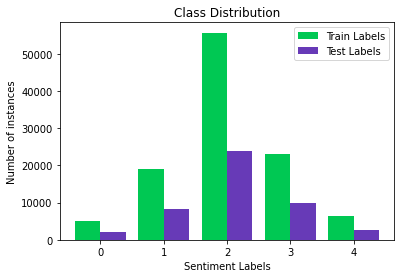

In [9]:
##
## Data visualization --> class imbalance between training and 
## testing data-sets using bar-plots
##

x_pos = np.arange(len(set(y_train)))

labels_tr = list(set(y_train))
labels_ts = list(set(y_test))

values_tr = list(traindf.values)
values_ts = list(testdf.values)

plt.bar(x_pos - 0.2, values_tr, width=0.4, color='#00C853', label='Train Labels')
plt.bar(x_pos + 0.2, values_ts, width=0.4, color='#673AB7', label='Test Labels')
plt.xticks(x_pos, labels_tr)
plt.legend(loc='upper right')
plt.xlabel('Sentiment Labels')
plt.ylabel('Number of instances')
plt.title('Class Distribution')
plt.show()

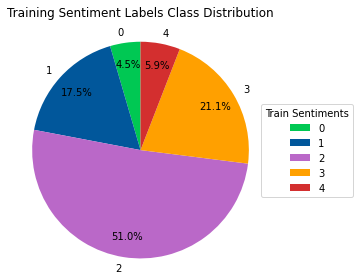

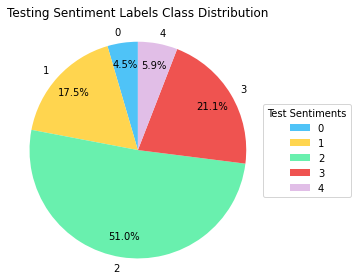

In [10]:
##
## Two separate pie-charts for visualizing class imbalance 
## in train and test data-sets
##

colors_tr = ['#00C853', '#01579B', '#BA68C8', '#FFA000', '#D32F2F']
colors_ts = ['#4FC3F7', '#FFD54F', '#69F0AE', '#EF5350', '#E1BEE7']

fig, ax = plt.subplots(figsize=(15,4))

ax.pie(x=values_tr, labels=labels_tr, startangle=90, autopct='%1.1f%%', radius=1.2, colors=colors_tr, pctdistance=0.8)

ax.legend(title='Train Sentiments',
          loc='center right',
          borderaxespad=-10)

plt.title('Training Sentiment Labels Class Distribution\n')
plt.tight_layout()
plt.show()



print()
print()



fig, ax = plt.subplots(figsize=(15,4))

ax.pie(x=values_ts, labels=labels_ts, startangle=90, autopct='%1.1f%%', radius=1.2, colors=colors_ts, pctdistance=0.8)

ax.legend(title='Test Sentiments',
          loc='center right',
          borderaxespad=-10)

plt.title('Testing Sentiment Labels Class Distribution\n')
plt.tight_layout()
plt.show()

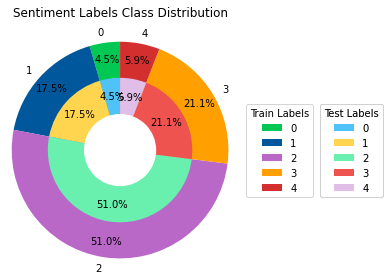

In [11]:
##
## Nested pie-charts for visualizing class imbalance 
## in train and test data-sets
##

colors_tr = ['#00C853', '#01579B', '#BA68C8', '#FFA000', '#D32F2F']
colors_ts = ['#4FC3F7', '#FFD54F', '#69F0AE', '#EF5350', '#E1BEE7']

fig, ax = plt.subplots()

pie_plots = []

pie_plots = np.append(pie_plots, ax.pie(x=values_tr, labels=labels_tr, startangle=90, autopct='%1.1f%%', radius=1.2, colors=colors_tr, pctdistance=0.85))
pie_plots = np.append(pie_plots, ax.pie(x=values_ts, startangle=90, autopct='%1.1f%%', radius=0.8, colors=colors_ts, pctdistance=0.75))

leg1 = ax.legend(pie_plots[:15], labels_tr, title='Train Labels', loc='center right', borderaxespad=-8)

leg2 = ax.legend(pie_plots[15:], labels_ts, title='Test Labels', loc='center right', borderaxespad=-15)

plt.gca().add_artist(leg1)
plt.gca().add_artist(leg2)

circle = plt.Circle((0,0), radius=0.4, fc='white')
fig1 = plt.gcf()
fig1.gca().add_artist(circle)

ax.set_title('Sentiment Labels Class Distribution\n')
plt.tight_layout()
plt.show()

In [12]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

punctuations = "?:!.,;()-/\""

remove_punctuations = True
remove_stopwords = True
use_lemma = False
use_stem = True

all_reviews = X.values
all_sentiments = Y.values

reviews = all_reviews

for r in range(len(all_reviews)):
    temp_review = []
    for word in word_tokenize(all_reviews[r]):
        new_word = word
        if remove_stopwords and (word in stop_words):
            continue
        if remove_punctuations and (word in punctuations):
            continue
        if use_stem:
            new_word = lancaster.stem(new_word)
        if use_lemma:
            new_word = lemmatizer.lemmatize(new_word)

        temp_review.append(new_word)

    reviews[r] = ' '.join(temp_review)

    if(r % 10000 == 0):
        print(str(r) + " records done.")

reviews = np.array(reviews)

all_data = pd.DataFrame(reviews, columns=['Phrase'])
all_labels = pd.DataFrame(all_sentiments, columns=['Sentiment'])

print()
print()
print('All Records Done')
print()
print()
print("Number of reviews in entire dataset = " + str(len(all_data)))
print("Number of sentiments in entire dataset = " + str(len(all_labels)))

0 records done.
10000 records done.
20000 records done.
30000 records done.
40000 records done.
50000 records done.
60000 records done.
70000 records done.
80000 records done.
90000 records done.
100000 records done.
110000 records done.
120000 records done.
130000 records done.
140000 records done.
150000 records done.


All Records Done


Number of reviews in entire dataset = 156060
Number of sentiments in entire dataset = 156060


In [13]:
# Try different kinds of vectorizers
# Also, try different n-gram ranges
# vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1), max_features=750)
vectorizer = CountVectorizer(max_features=100)

reviews = vectorizer.fit_transform(all_data['Phrase'])
labels = all_labels['Sentiment']

print('='*30)
print("\tBefore Vectorizing")
print('-'*30)
print("Train data = " + str(x_train.shape))
print("Test data = " + str(x_test.shape))
print('='*30)

x_tr = vectorizer.transform(x_train)
x_ts = vectorizer.transform(x_test)

print()
print()
print('='*30)
print("\tAfter Vectorizing")
print('-'*30)
print("Train data = " + str(x_tr.shape))
print("Test data = " + str(x_ts.shape))
print('='*30)

	Before Vectorizing
------------------------------
Train data = (109242,)
Test data = (46818,)


	After Vectorizing
------------------------------
Train data = (109242, 100)
Test data = (46818, 100)


In [14]:
x_train_np = x_tr.toarray()
y_train_np = np.array(y_train)
print("Train set done...")

x_test_np = x_ts.toarray()
y_test_np = np.array(y_test)
print("Test set done...")

Train set done...
Test set done...


In [15]:
import gc
gc.collect()

5559

In [0]:
from sklearn.preprocessing import LabelBinarizer
from torch.nn.functional import softmax, sigmoid

class CnnModel(torch.nn.Module):

    def __init__(self, batch_size, inputs, outputs):
        # Initialize super class and store the parameters
        super(CnnModel, self).__init__()
        
        # batch_size for dataset
        self.batch_size = batch_size
        # Number of input channels
        self.inputs = inputs
        # Number of output channels
        self.outputs = outputs

        # Conv1d(input channels, output channels, kernel size)
        self.input_layer = Conv1d(inputs, batch_size, 1)

        # MaxPool1d(kernel size)
        self.max_pooling_layer1 = MaxPool1d(1)

        # Convolution layer
        self.conv_layer1 = Conv1d(batch_size, 64, 1)

         # MaxPool1d(kernel size)
        # self.max_pooling_layer2 = MaxPool1d(1)

        # Convolution layer
        # self.conv_layer2 = Conv1d(64, 128, 1)

        # Define a flatten layer
        self.flatten_layer = Flatten()

        # Linear(inputs, outputs)
        self.linear_layer = Linear(64, 32)

        # Finally, the output layer
        self.output_layer = Linear(32, outputs)
        
    # Define a method to feed inputs through the model
    def feed(self, input_data):

        # Needs 3D input
        input_data = input_data.reshape((self.batch_size, self.inputs, 1))

        # Get output from all layers given "input_data" as input
        output = relu(self.input_layer(input_data))
        output = self.max_pooling_layer1(output)
        output = relu(self.conv_layer1(output))
        # Flatten Layer
        output = self.flatten_layer(output)
        # Fully Connected Layers
        output = self.linear_layer(output)
        output = self.output_layer(output)
        output = softmax(output)
        
        # Use sigmoid float for loss function, and use round to get one of 0
        # and 1 for binary classification
        output_ = torch.round(output)

        # Finally, return the output obtained at the end
        return output, output_
        # return output

In [0]:
def model_loss(model, dataset, train=False, optimizer=None):

    performance = L1Loss()
    criterion = CrossEntropyLoss().cuda()
    accu = Accuracy()
    prec = Precision()
    rec = Recall()

    avg_accu = 0
    avg_loss = 0
    avg_prec = 0
    avg_rec = 0
    count = 0

    for input_, output in iter(dataset):
        predictions, preds_ = model.feed(input_)

        labels = np.array(output.cpu().argmax(dim=1).squeeze(0))
    
        actual = torch.from_numpy(labels).cuda()

        loss = criterion(predictions, actual)

        accu.update([preds_, output])
        tmp_accu = accu.compute()

        # tmp_accu = categorical_accuracy(predictions, output)

        prec.update([preds_, output])
        tmp_prec = prec.compute()
        
        rec.update([preds_, output])
        tmp_rec = rec.compute()

        if(train):
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        avg_loss += loss.item()
        avg_accu += tmp_accu
        avg_prec += tmp_prec.item()
        avg_rec += tmp_rec.item()

        count += 1

    return avg_loss/count, avg_accu/count, avg_prec/count, avg_rec/count
    # return avg_accu/count, avg_prec/count, avg_rec/count
    # return avg_loss/count, avg_accu/count

In [0]:
label_bin = LabelBinarizer()

x_train_np = x_train_np.reshape((x_train_np.shape[0], x_train_np.shape[1], 1))
x_test_np = x_test_np.reshape((x_test_np.shape[0], x_test_np.shape[1], 1))

y_train_oh = label_bin.fit_transform(y_train_np)
y_train_oh = np.array(y_train_oh)
y_test_oh = label_bin.transform(y_test_np)
y_test_oh = np.array(y_test_oh)

In [0]:
torch.cuda.empty_cache()

In [0]:
print(y_train_np.shape)

(109242,)


In [19]:
x_tr_np = x_tr.toarray()
x_ts_np = x_ts.toarray()

print(x_tr_np.shape)
print(x_ts_np.shape)

y_tr_np = np.array(y_train_oh)
y_ts_np = np.array(y_test_oh)

print(y_tr_np.shape)
print(y_ts_np.shape)

(109242, 100)
(46818, 100)
(109242, 5)
(46818, 5)


In [35]:
batch_size = 32

# Model for optimizer-1 (Adam)
model_torch1 = CnnModel(batch_size, x_tr.shape[1], y_train_oh.shape[1])
# Model for optimizer-2 (RMSprop)
model_torch2 = CnnModel(batch_size, x_tr.shape[1], y_train_oh.shape[1])

model_torch1.cuda()
model_torch2.cuda()

CnnModel(
  (input_layer): Conv1d(100, 32, kernel_size=(1,), stride=(1,))
  (max_pooling_layer1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
  (linear_layer): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=5, bias=True)
)

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Model: \"PyTorch\"')
print('-'*25)
print('    Optimizer\tParams')
print('='*25)
print('1.  Adam\t' + str(count_parameters(model_torch1)))
print('2.  RMSprop\t' + str(count_parameters(model_torch2)))
print('='*25)

Model: "PyTorch"
-------------------------
    Optimizer	Params
1.  Adam	7589
2.  RMSprop	7589



Trained model exists in directory : False



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


--------------------------------------------------
Epoch 1
	ADAM optimizer:
		Accuracy = 0.802496741230491
		F1-Score = 0.3969942988220535
		Precision = 0.46373025420108394
		Recall = 0.3470499417010053
	RMSprop optimizer:
		Accuracy = 0.8032985633397332
		F1-Score = 0.4367641657534799
		Precision = 0.48336780050463285
		Recall = 0.3983568171699791
--------------------------------------------------
Epoch 2
	ADAM optimizer:
		Accuracy = 0.804365052934508
		F1-Score = 0.5098619534754376
		Precision = 0.5109677160860471
		Recall = 0.5087609663941298
	RMSprop optimizer:
		Accuracy = 0.8084936981729863
		F1-Score = 0.5117332266219013
		Precision = 0.5221117003068144
		Recall = 0.5017593152041978
--------------------------------------------------
Epoch 3
	ADAM optimizer:
		Accuracy = 0.8110266341833123
		F1-Score = 0.5137559950662246
		Precision = 0.5292294398567202
		Recall = 0.4991616625420045
	RMSprop optimizer:
		Accuracy = 0.8092253407806541
		F1-Score = 0.5165240456684094
		Precision =

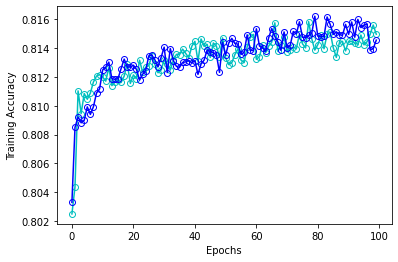

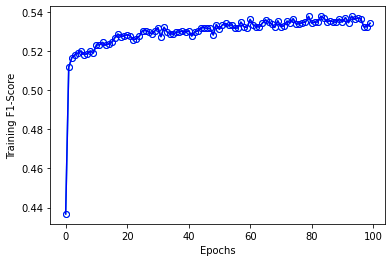

In [0]:
##
## Try creating subsets of the dataset, and individually passing them to
## the torch Variable to create Tensors, and finally using thse individual
## tensors one-at-a-time to feed to the network. This can help (might) to
## overcome the problem of GPU running out of memory...
##

from torch.optim import Adam, SGD, Rprop, RMSprop
import os

model_name = '1116823_1dconv_sentiment.pt'
sep = '/'
drive_path = '/content/drive/My Drive'

model_path = drive_path + sep + model_name

print()
print("Trained model exists in directory : " + str(model_name in list(os.listdir(drive_path))))
print()

if(model_name not in list(os.listdir(drive_path))):

    epochs = 100
    plot_epochs = range(epochs)

    optimizer1 = Adam(model_torch1.parameters(), lr=1e-4)
    # optimizer2 = SGD(model_torch.parameters(), lr=1e-5)
    # optimizer2 = Rprop(model_torch.parameters(), lr=1e-5)
    optimizer2 = RMSprop(model_torch2.parameters(), lr=1e-4)

    # Convert the training set into torch variables for our model using the GPU
    inputs = torch.from_numpy(x_tr_np).cuda().float()
    outputs = torch.from_numpy(y_tr_np).cuda().float()

    # Create a DataLoader instance to work with our batches
    tensor = TensorDataset(inputs, outputs)
    # drop_last drops the last n%batch_size records
    loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

    all_acc1 = []
    all_f11 = []

    all_acc2 = []
    all_f12 = []

    for epoch in range(epochs):
        # Cycle through the batches and get average loss
        avg_loss1, avg_accu1, avg_prec1, avg_rec1 = model_loss(model_torch1, loader, train=True, optimizer=optimizer1)
        avg_loss2, avg_accu2, avg_prec2, avg_rec2 = model_loss(model_torch2, loader, train=True, optimizer=optimizer2)

        f1_score1 = (2*(avg_prec1 * avg_rec1) / (avg_prec1 + avg_rec1))
        f1_score2 = (2*(avg_prec2 * avg_rec2) / (avg_prec2 + avg_rec2))

        all_acc1.append(avg_accu1)
        all_f11.append(f1_score1)

        all_acc2.append(avg_accu2)
        all_f12.append(f1_score2)

        print('-'*50)
        print("Epoch " + str(epoch+1) + "\n\tADAM optimizer:" + "\n\t\tAccuracy = " + str(avg_accu1) + "\n\t\tF1-Score = " + str(f1_score1) + "\n\t\tPrecision = " + str(avg_prec1) + "\n\t\tRecall = " + str(avg_rec1))
        print("\tRMSprop optimizer:" + "\n\t\tAccuracy = " + str(avg_accu2) + "\n\t\tF1-Score = " + str(f1_score2) + "\n\t\tPrecision = " + str(avg_prec2) + "\n\t\tRecall = " + str(avg_rec2))

    print('-'*50)
    plt.plot(plot_epochs, all_acc1, 'oc-', fillstyle='none', label='Adam')
    plt.plot(plot_epochs, all_acc2, 'ob-', fillstyle='none', label='RMSprop')
    plt.xlabel('Epochs')
    plt.ylabel('Training Accuracy')
    plt.show()

    plt.plot(plot_epochs, all_f12, 'oc-', fillstyle='none', label='Adam')
    plt.plot(plot_epochs, all_f12, 'ob-', fillstyle='none', label='RMSprop')
    plt.xlabel('Epochs')
    plt.ylabel('Training F1-Score')
    plt.show()

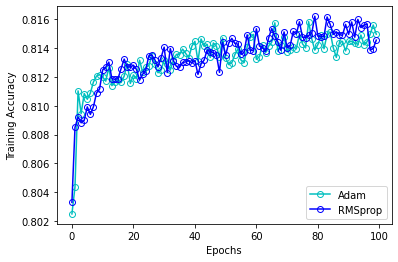

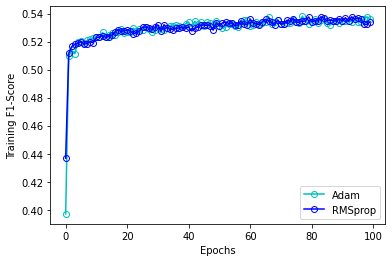

In [0]:
plt.plot(plot_epochs, all_acc1, 'oc-', fillstyle='none', label='Adam')
plt.plot(plot_epochs, all_acc2, 'ob-', fillstyle='none', label='RMSprop')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(plot_epochs, all_f11, 'oc-', fillstyle='none', label='Adam')
plt.plot(plot_epochs, all_f12, 'ob-', fillstyle='none', label='RMSprop')
plt.xlabel('Epochs')
plt.ylabel('Training F1-Score')
plt.legend(loc='lower right')
plt.show()

In [0]:
## We will choose the model with higher average training accuracy as
## our final model implemented in PyTorch
final_acc_adam = all_acc1[-1]
final_acc_rms = all_acc2[-1]

# Variable to check which model to be used (Adam-optimized or RMSprop-optimized)
flag = 0

print("Adam Final Accuracy\t= " + str(final_acc_adam))
print("RMSprop Final Accuracy\t= " + str(final_acc_rms))
print('-'*50)

if(final_acc_adam > final_acc_rms):
    flag = 0
    print("Adam-optimized model is the final model.")
else:
    flag = 1
    print("RMSprop-optimized model is the final model.")

Adam Avg. Accuracy	= 0.8132591203160282
RMSprop Avg. Accuracy	= 0.813451604233644
--------------------------------------------------
RMSprop-optimized model is the final model.


## Saving and Loading the model

In [0]:
## Select the final model to be using RMSprop optimizer
if(flag == 0):
    # Choose Adam-optimized model
    final_model = model_torch1
elif(flag == 1):
    # Choose RMSprop-optimized model
    final_model = model_torch2

torch.save(final_model, model_path)

print()
print('-'*100)
print("Trained model saved as \"{}\" in the location \"{}\"".format(model_name, drive_path))
print('-'*100)
print()


----------------------------------------------------------------------------------------------------
Trained model saved as "1116823_1dconv_sentiment.pt" in the location "/content/drive/My Drive"
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
loaded_model = torch.load(model_path)
loaded_model.eval()

CnnModel(
  (input_layer): Conv1d(100, 32, kernel_size=(1,), stride=(1,))
  (max_pooling_layer1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=5, bias=True)
)

## Model Testing

In [0]:
if(flag == 0):
    optimizer = Adam(loaded_model.parameters(), lr=1e-4)
elif(flag == 1):
    optimizer = RMSprop(loaded_model.parameters(), lr=1e-4)

# Convert the training set into torch variables for our model using the GPU
inputs = torch.from_numpy(x_ts_np).cuda().float()
outputs = torch.from_numpy(y_ts_np).cuda().float()

# Create a DataLoader instance to work with our batches
tensor = TensorDataset(inputs, outputs)
# drop_last drops the last n%batch_size records
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

avg_loss, avg_accu, avg_prec, avg_rec = model_loss(loaded_model, loader, train=False, optimizer=optimizer)

f1_score = (2*(avg_prec * avg_rec) / (avg_prec + avg_rec))

print('-'*50)
print("\t\tTesting Results")
print('-'*50)
print("\tRMSprop optimizer:" + "\n\t\tAccuracy = " + str(avg_accu) + "\n\t\tF1-Score = " + str(f1_score) + "\n\t\tPrecision = " + str(avg_prec) + "\n\t\tRecall = " + str(avg_rec))
print('-'*50)
print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


--------------------------------------------------
		Testing Results
--------------------------------------------------
	RMSprop optimizer:
		Accuracy = 0.8122098131496247
		F1-Score = 0.5278499135693059
		Precision = 0.5308773110491751
		Recall = 0.5248568485662054
--------------------------------------------------



# Keras Implementation

### Import keras libraries

In [20]:
import keras
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, Dense, Flatten, Activation, Dropout
from keras.optimizers import Adam as adam_opt
from keras.optimizers import RMSprop as rms_opt

Using TensorFlow backend.


### Create separate optimizers and use in loop with the same architecture of the keras-model

In [0]:
##
## Helper function to build the model with the defined architecture
##

def build_model():
    model = keras.Sequential()

    model.add(Conv1D(32, 1, activation='relu', input_shape=(x_train_np.shape[1], 1)))
    model.add(MaxPooling1D(1))
    model.add(Conv1D(128, 1, activation='relu'))
    model.add(MaxPooling1D(1))
    model.add(Conv1D(256, 1, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    return model

In [28]:
# Temporary model built to check the number of parameters 
# of the network which will be trained

temp_model = build_model()
temp_model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=adam_opt())

temp_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 100, 32)           64        
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 100, 32)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 100, 128)          4224      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 100, 128)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 100, 256)          33024     
_________________________________________________________________
flatten_8 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)             

In [26]:
opt1 = adam_opt(lr=0.001)
opt2 = rms_opt(lr=0.001)

optimizers = [opt1, opt2]

all_models = []

curr_opt = 1
for optimizer in optimizers:
    print()
    print("Training Run for Optimizer #" + str(curr_opt))
    print()
    curr_opt = curr_opt + 1

    model = build_model()

    model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=optimizer)

    history = model.fit(x_train_np, y_train_oh, epochs=50, batch_size=1024, shuffle=True, validation_data=(x_test_np, y_test_oh))

    # Get y_predicted from the model
    y = model.predict(x_test_np)
    
    # Get predicted and true labels from one-hot encoded format
    y_true = np.argmax(y_test_oh, axis=1)
    y_pred = np.argmax(y, axis=1)

    # Model evaluation metrics
    acc = history.history['val_acc'][-1]
    prec = precision_score(y_true, y_pred, zero_division=1, average='weighted')
    rec = recall_score(y_true, y_pred, zero_division=1, average='weighted')
    f1 = f1_score(y_true, y_pred, zero_division=1, average='weighted')

    print()
    print('\n\tAccuracy = ' + str(acc))
    print('\tPrecision = ' + str(prec))
    print('\tRecall = ' + str(rec))
    print('\tF1-Score = ' + str(f1))

    all_models.append(history)

    print()
    print()


Training Run for Optimizer #1

Train on 109242 samples, validate on 46818 samples
Epoch 1/50
109242/109242 [==============================] - 7s 61us/step - loss: 1.2822 - acc: 0.5110 - val_loss: 1.2429 - val_acc: 0.5222
Epoch 2/50
109242/109242 [==============================] - 5s 50us/step - loss: 1.2513 - acc: 0.5203 - val_loss: 1.2356 - val_acc: 0.5227
Epoch 3/50
109242/109242 [==============================] - 5s 49us/step - loss: 1.2463 - acc: 0.5219 - val_loss: 1.2336 - val_acc: 0.5233
Epoch 4/50
109242/109242 [==============================] - 5s 49us/step - loss: 1.2431 - acc: 0.5225 - val_loss: 1.2324 - val_acc: 0.5247
Epoch 5/50
109242/109242 [==============================] - 5s 49us/step - loss: 1.2404 - acc: 0.5240 - val_loss: 1.2306 - val_acc: 0.5269
Epoch 6/50
109242/109242 [==============================] - 5s 49us/step - loss: 1.2367 - acc: 0.5251 - val_loss: 1.2317 - val_acc: 0.5249
Epoch 7/50
109242/109242 [==============================] - 5s 50us/step - loss: 1.

## Plot simulatenous graphs to view performances with different optimizers

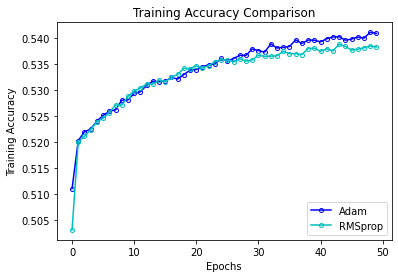

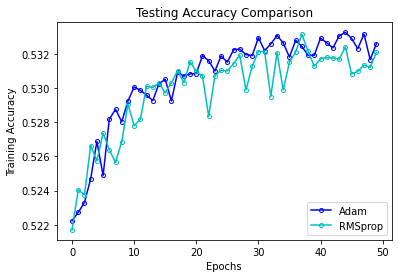

In [31]:
acc_opt1 = all_models[0].history['acc']
acc_opt2 = all_models[1].history['acc']

val_opt1 = all_models[0].history['val_acc']
val_opt2 = all_models[1].history['val_acc']

epochs = range(50)

plt.plot(epochs, acc_opt1, 'b-', markersize=4, marker='o', fillstyle='none', label='Adam')
plt.plot(epochs, acc_opt2, 'c-', markersize=4, marker='o', fillstyle='none', label='RMSprop')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Comparison')
plt.show()

print()

plt.plot(epochs, val_opt1, 'b-', markersize=4, marker='o', fillstyle='none', label='Adam')
plt.plot(epochs, val_opt2, 'c-', markersize=4, marker='o', fillstyle='none', label='RMSprop')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Testing Accuracy Comparison')
plt.show()